# Discrete Markov Chain Distribution

In [1]:
%%capture
!pip install statsmodels

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import statsmodels.api as sm

from matplotlib import ticker as mtick

from pymc_extras.distributions.timeseries import DiscreteMarkovChain

## Demonstration of API 

In [3]:
with pm.Model() as model:
    logit_P = pm.Normal("logit_P", sigma=0.1, size=(3, 3))
    k = logit_P.shape[-1]
    init_dist = pm.Categorical.dist(p=pt.full((k,), 1 / k))
    discrete_mc = DiscreteMarkovChain("MarkovChain", logit_P=logit_P, init_dist=init_dist, steps=10)

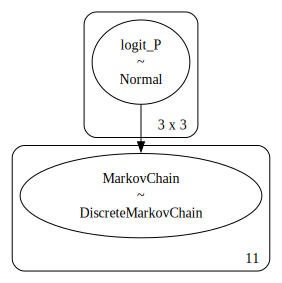

In [4]:
model.to_graphviz()

Dims of the output are `(batch, time)`.

In [5]:
pm.draw(discrete_mc, 10)

array([[1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2],
       [0, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2],
       [2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 1],
       [1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2],
       [1, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0],
       [0, 0, 1, 2, 0, 1, 0, 1, 1, 2, 1],
       [2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 0],
       [2, 2, 1, 0, 0, 0, 2, 0, 1, 1, 1],
       [2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 2],
       [1, 0, 2, 0, 1, 0, 2, 1, 0, 2, 2]])

## Parameter Recovery

Estimate the transition matrix $P$ from data, using `DiscreteMarkovChain` as a likelihood

In [6]:
true_P = np.array([[0.6, 0.2, 0.2], [0.5, 0.1, 0.4], [0.1, 0.1, 0.8]])


def generate_chains(P, steps, n_chains=1):
    output = np.empty((n_chains, steps), dtype="int64")

    x0 = pm.draw(pm.Categorical.dist(p=[0.5, 0.5, 0], shape=(n_chains,)))
    output[:, 0] = x0

    for t in range(1, steps):
        output[:, t] = [
            np.random.choice(range(P.shape[0]), p=P[output[i, t - 1]].ravel()).astype(int)
            for i in range(n_chains)
        ]

    return output.squeeze()

In [7]:
chains = generate_chains(true_P, 100, n_chains=100)

In [8]:
with pm.Model() as model:
    x0 = pm.Categorical.dist(np.ones(3) / 3, size=(100,))
    P = pm.Dirichlet("P", a=[1, 1, 1], size=(3,))
    discrete_mc = DiscreteMarkovChain("MarkovChain", P=P, init_dist=x0, observed=chains)
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [P]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


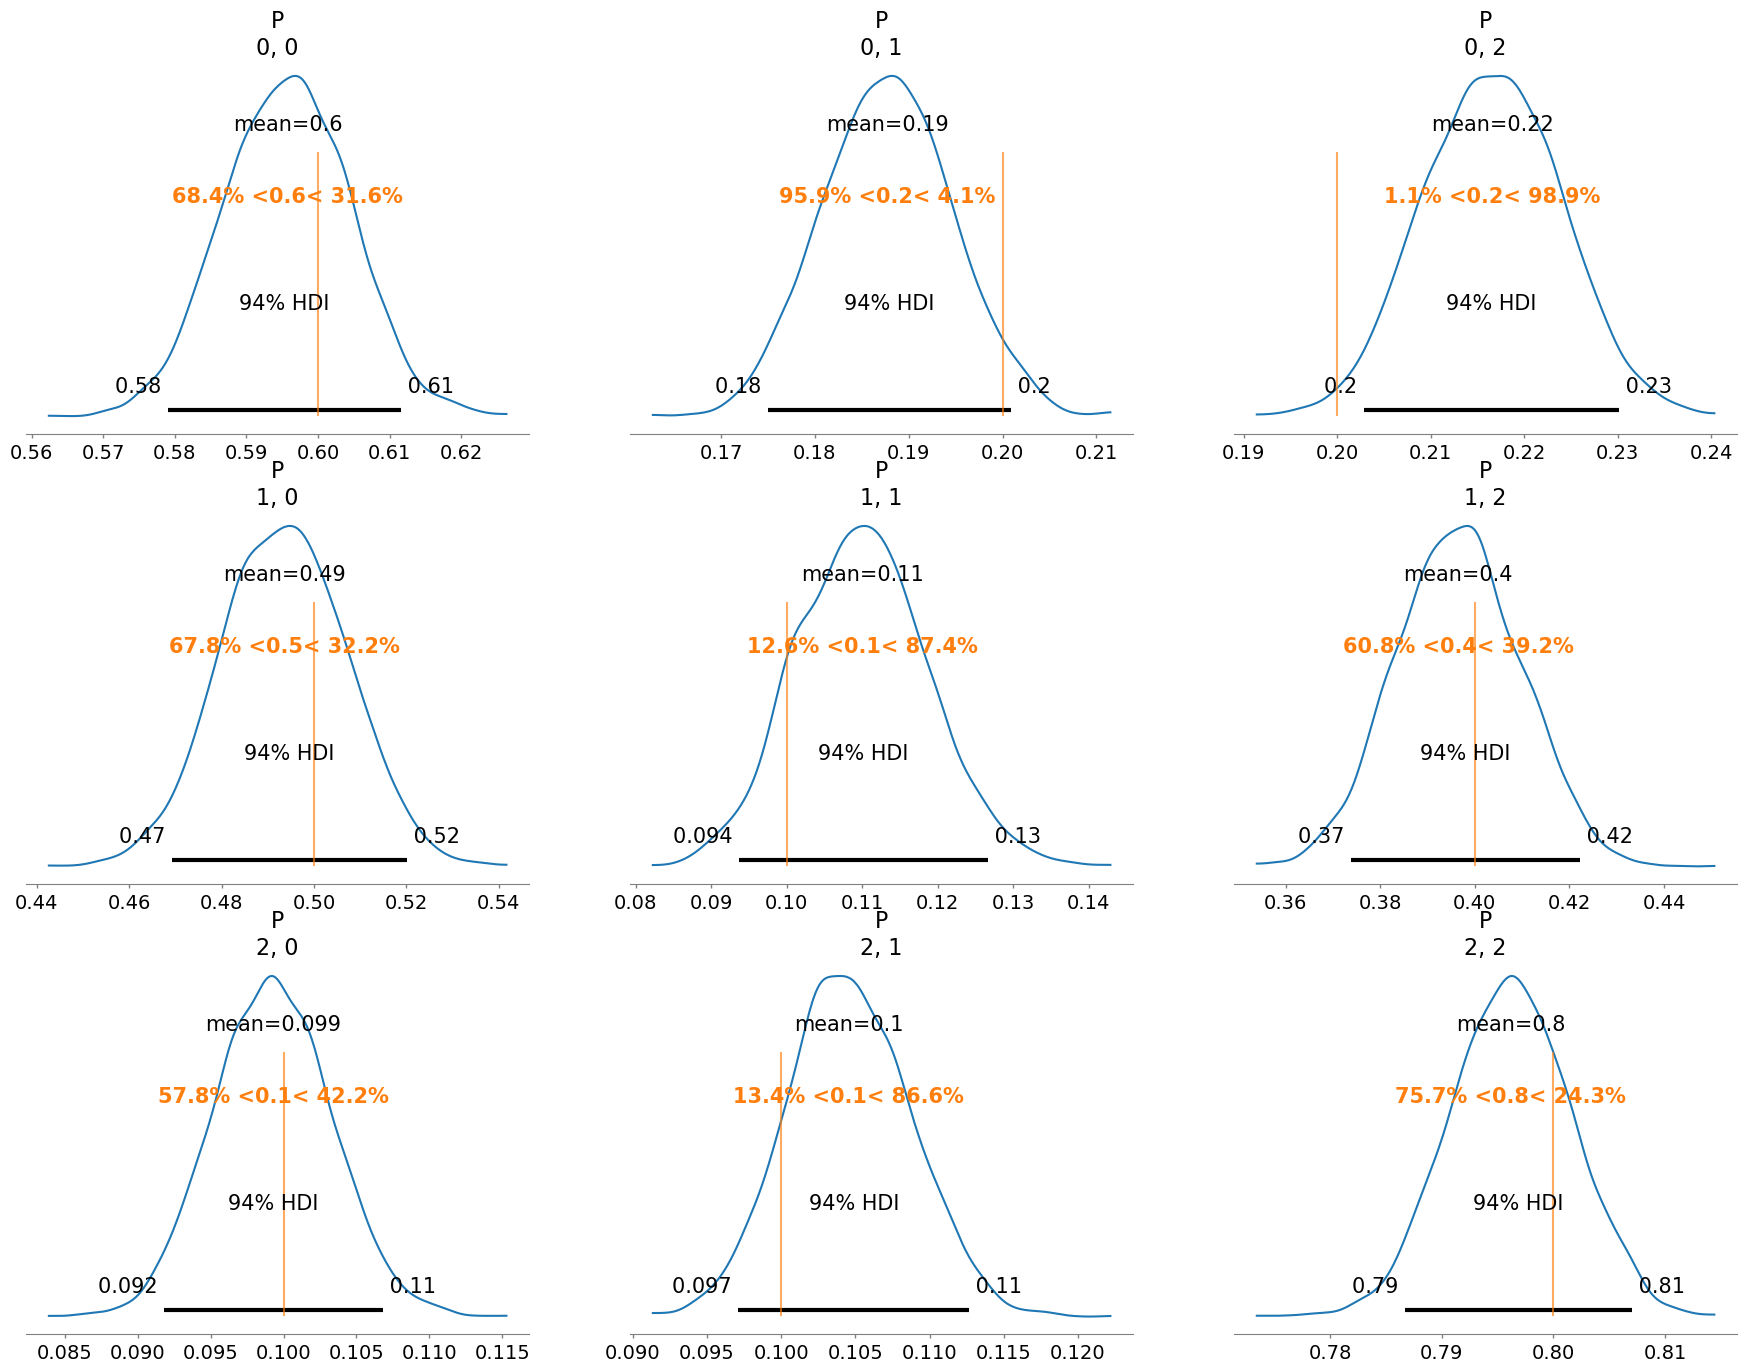

In [9]:
az.plot_posterior(idata, ref_val=true_P.ravel().tolist());

## Hidden markov model

Use `DiscreteMarkovChain` as a latent variable in a Hidden Markov Model. This example (along with data) is taken from the statsmodels documentation found here:

https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html

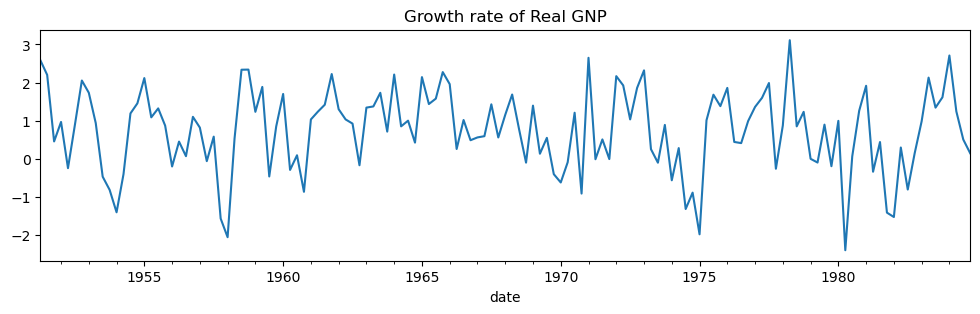

In [10]:
# Get the RGNP data to replicate Hamilton
storage_options = {"User-Agent": "Mozilla/5.0"}
dta = pd.read_stata(
    "https://www.stata-press.com/data/r14/rgnp.dta", storage_options=storage_options
).iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq="QS")
dta_hamilton = dta.rgnp

# Plot the data
dta_hamilton.plot(title="Growth rate of Real GNP", figsize=(12, 3))

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

In [11]:
res_hamilton.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     rgnp   No. Observations:                  131
Model:             MarkovAutoregression   Log Likelihood                -181.263
Date:                  Sun, 01 Jun 2025   AIC                            380.527
Time:                          18:50:54   BIC                            406.404
Sample:                      04-01-1951   HQIC                           391.042
                           - 10-01-1984                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3588      0.265     -1.356      0.175      -0.877       0.160
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1635      0.075     15.614      0.000       1.017       1.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.5914      0.103      5.761      0.000       0.390       0.793
ar.L1          0.0135      0.120      0.112      0.911      -0.222       0.249
ar.L2         -0.0575      0.138     -0.418      0.676      -0.327       0.212
ar.L3         -0.2470      0.107     -2.310      0.021      -0.457      -0.037
ar.L4         -0.2129      0.111     -1.926      0.054      -0.430       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.7547      0.097      7.819      0.000       0.565       0.944
p[1->0]        0.0959      0.038      2.542      0.011       0.022       0.170
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [12]:
T = dta_hamilton.shape[0]
order = 4

coords = {
    "dates": dta_hamilton.index,
    "obs_dates": dta_hamilton.index[order:],
    "states": ["State_1", "State_2"],
    "ar_params": [f"L{i + 1}.phi" for i in range(order)],
}

with pm.Model(coords=coords) as hmm:
    y = pm.Data("y", dta_hamilton, dims="dates")
    yobs = pm.Data("yobs", dta_hamilton.iloc[4:], dims=["obs_dates"])

    # If there are only 2 states, Bernoulli is accepted as an init_dist
    s0 = pm.Bernoulli.dist(p=0.5)
    P = pm.Dirichlet("P", a=[1.0, 1.0], size=(2,))
    hidden_states = DiscreteMarkovChain(
        "hidden_states", P=P, init_dist=s0, steps=T - 1, dims=["dates"]
    )

    state_mus = pm.Normal(
        "state_mus",
        dims=["states"],
        transform=pm.distributions.transforms.ordered,
        initval=[-1, 1],
    )
    ar_coefs = pm.Normal("coefs", size=order, dims=["ar_params"])

    def AR_step(s, L1_s, L2_s, L3_s, L4_s, L1_y, L2_y, L3_y, L4_y, mus, phis):
        y_out = (
            mus[s]
            + phis[0] * (L1_y - mus[L1_s])
            + phis[1] * (L2_y - mus[L2_s])
            + phis[2] * (L3_y - mus[L3_s])
            + phis[3] * (L4_y - mus[L4_s])
        )

        return y_out

    result, updates = pytensor.scan(
        AR_step,
        sequences=[
            {"input": hidden_states, "taps": [0, -1, -2, -3, -4]},
            {"input": y, "taps": [-1, -2, -3, -4]},
        ],
        non_sequences=[state_mus, ar_coefs],
    )

    sigma = pm.HalfCauchy("sigma", 0.8)
    obs = pm.Normal("y_hat", mu=result, sigma=sigma, observed=yobs, dims=["obs_dates"])

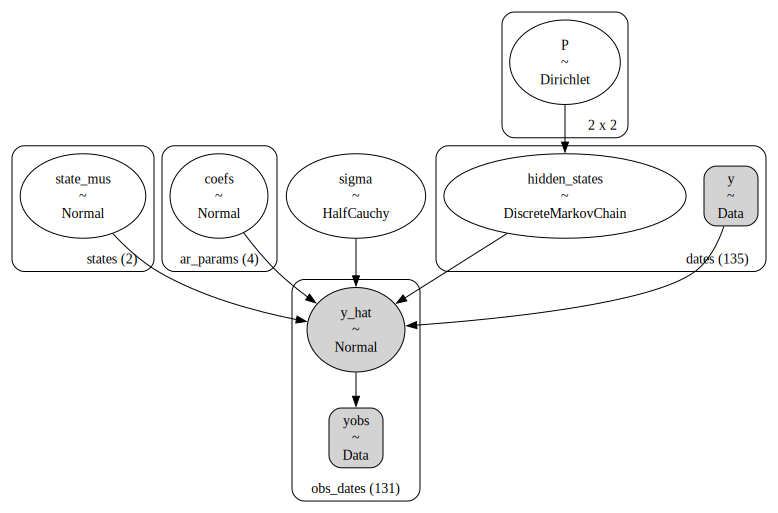

In [13]:
pm.model_to_graphviz(hmm)

It's quite difficult to sample this model, so I use a very high `target_accept` and a very large number of draws. It seems to be hard to get a sufficient number of effective samples for rare rates without a lot of draws. 

In [14]:
with hmm:
    # Need to assign BinaryMetropolis by hand, defaults to Metropolis and breaks.
    # BinaryGibbsMetropois seems to do much beter than BinaryMetropolis, but also much slower.
    idata = pm.sample(
        step=[
            pm.BinaryGibbsMetropolis([hidden_states]),
            pm.NUTS([P, state_mus, ar_coefs, sigma], target_accept=0.99),
        ],
        draws=5_000,
    )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [hidden_states]
>NUTS: [P, state_mus, coefs, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1829 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Post-Estimation Diagnostics

Energy plot looks awful...

<Axes: >

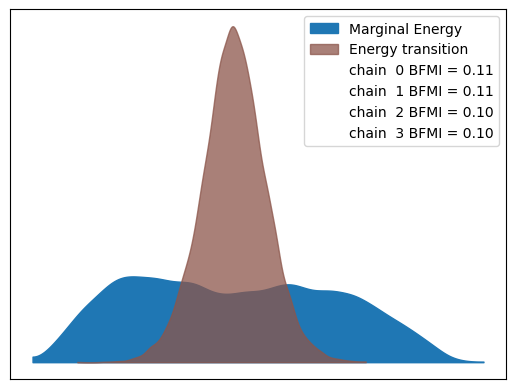

In [15]:
az.plot_energy(idata)

...but the trace plots look great! 

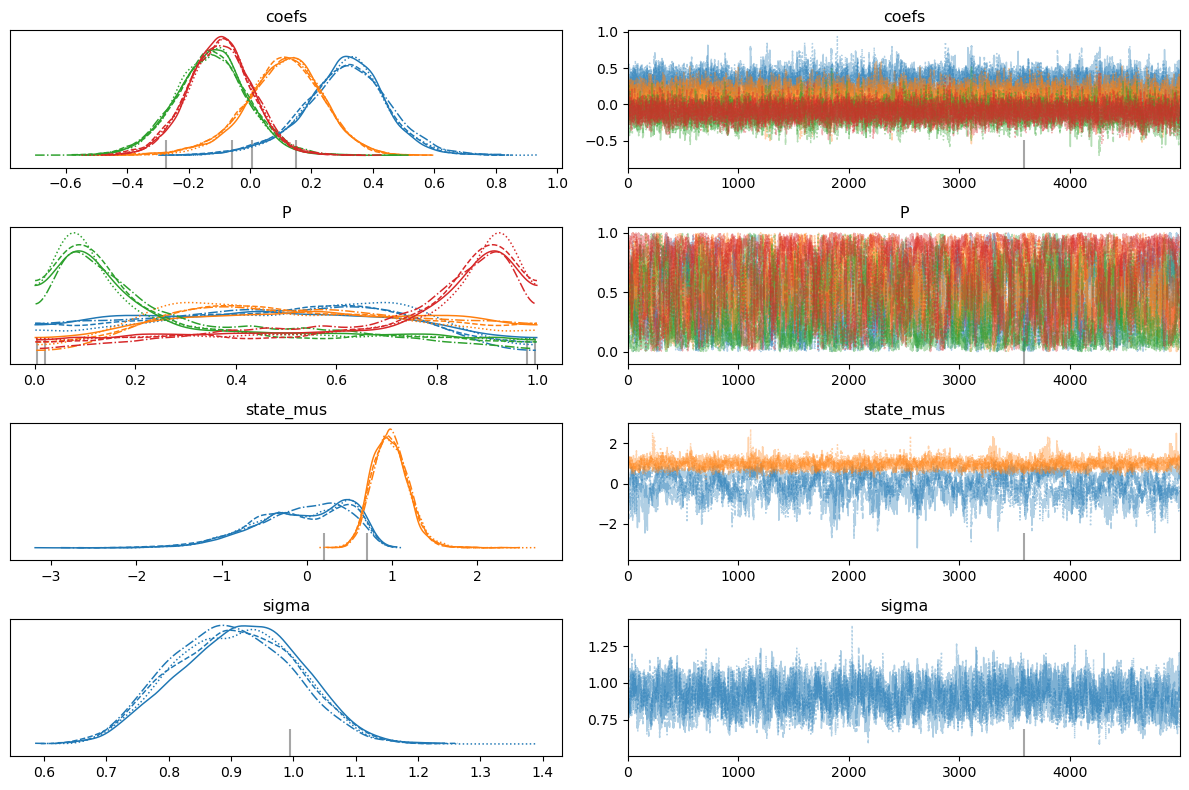

In [16]:
az.plot_trace(idata, var_names=["~hidden_states"])
plt.tight_layout();

Even after 20,000 draws, we only have about 500 samples for the transition probabilities to the more rare state 1.

In [17]:
az.summary(idata, var_names=["~hidden_states"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[L1.phi],0.307,0.139,0.029,0.567,0.006,0.003,571.0,1107.0,1.00
coefs[L2.phi],0.107,0.129,-0.129,0.359,0.003,0.002,2275.0,2242.0,1.00
coefs[L3.phi],-0.125,0.120,-0.350,0.098,0.002,0.002,2814.0,4192.0,1.00
coefs[L4.phi],-0.098,0.106,-0.297,0.103,0.002,0.001,2306.0,3475.0,1.00
"P[0, 0]",0.470,0.247,0.000,0.837,0.012,0.005,443.0,512.0,1.01
"P[0, 1]",0.530,0.247,0.163,1.000,0.012,0.005,443.0,512.0,1.01
"P[1, 0]",0.296,0.264,0.000,0.824,0.021,0.010,159.0,538.0,1.02
"P[1, 1]",0.704,0.264,0.176,1.000,0.021,0.010,159.0,538.0,1.02
state_mus[State_1],-0.068,0.561,-1.074,0.804,0.038,0.012,219.0,1162.0,1.01
state_mus[State_2],0.982,0.215,0.596,1.372,0.008,0.005,781.0,1639.0,1.00


## Comparison with Statsmodels

In [18]:
ref_vals = res_hamilton.params.copy()
ref_vals["p[0->1]"] = 1 - ref_vals["p[0->0]"]
ref_vals["p[1->1]"] = 1 - ref_vals["p[1->0]"]
ref_vals["sigma"] = np.sqrt(ref_vals["sigma2"])
ref_vals.drop("sigma2", inplace=True)
ref_vals.sort_index(inplace=True)

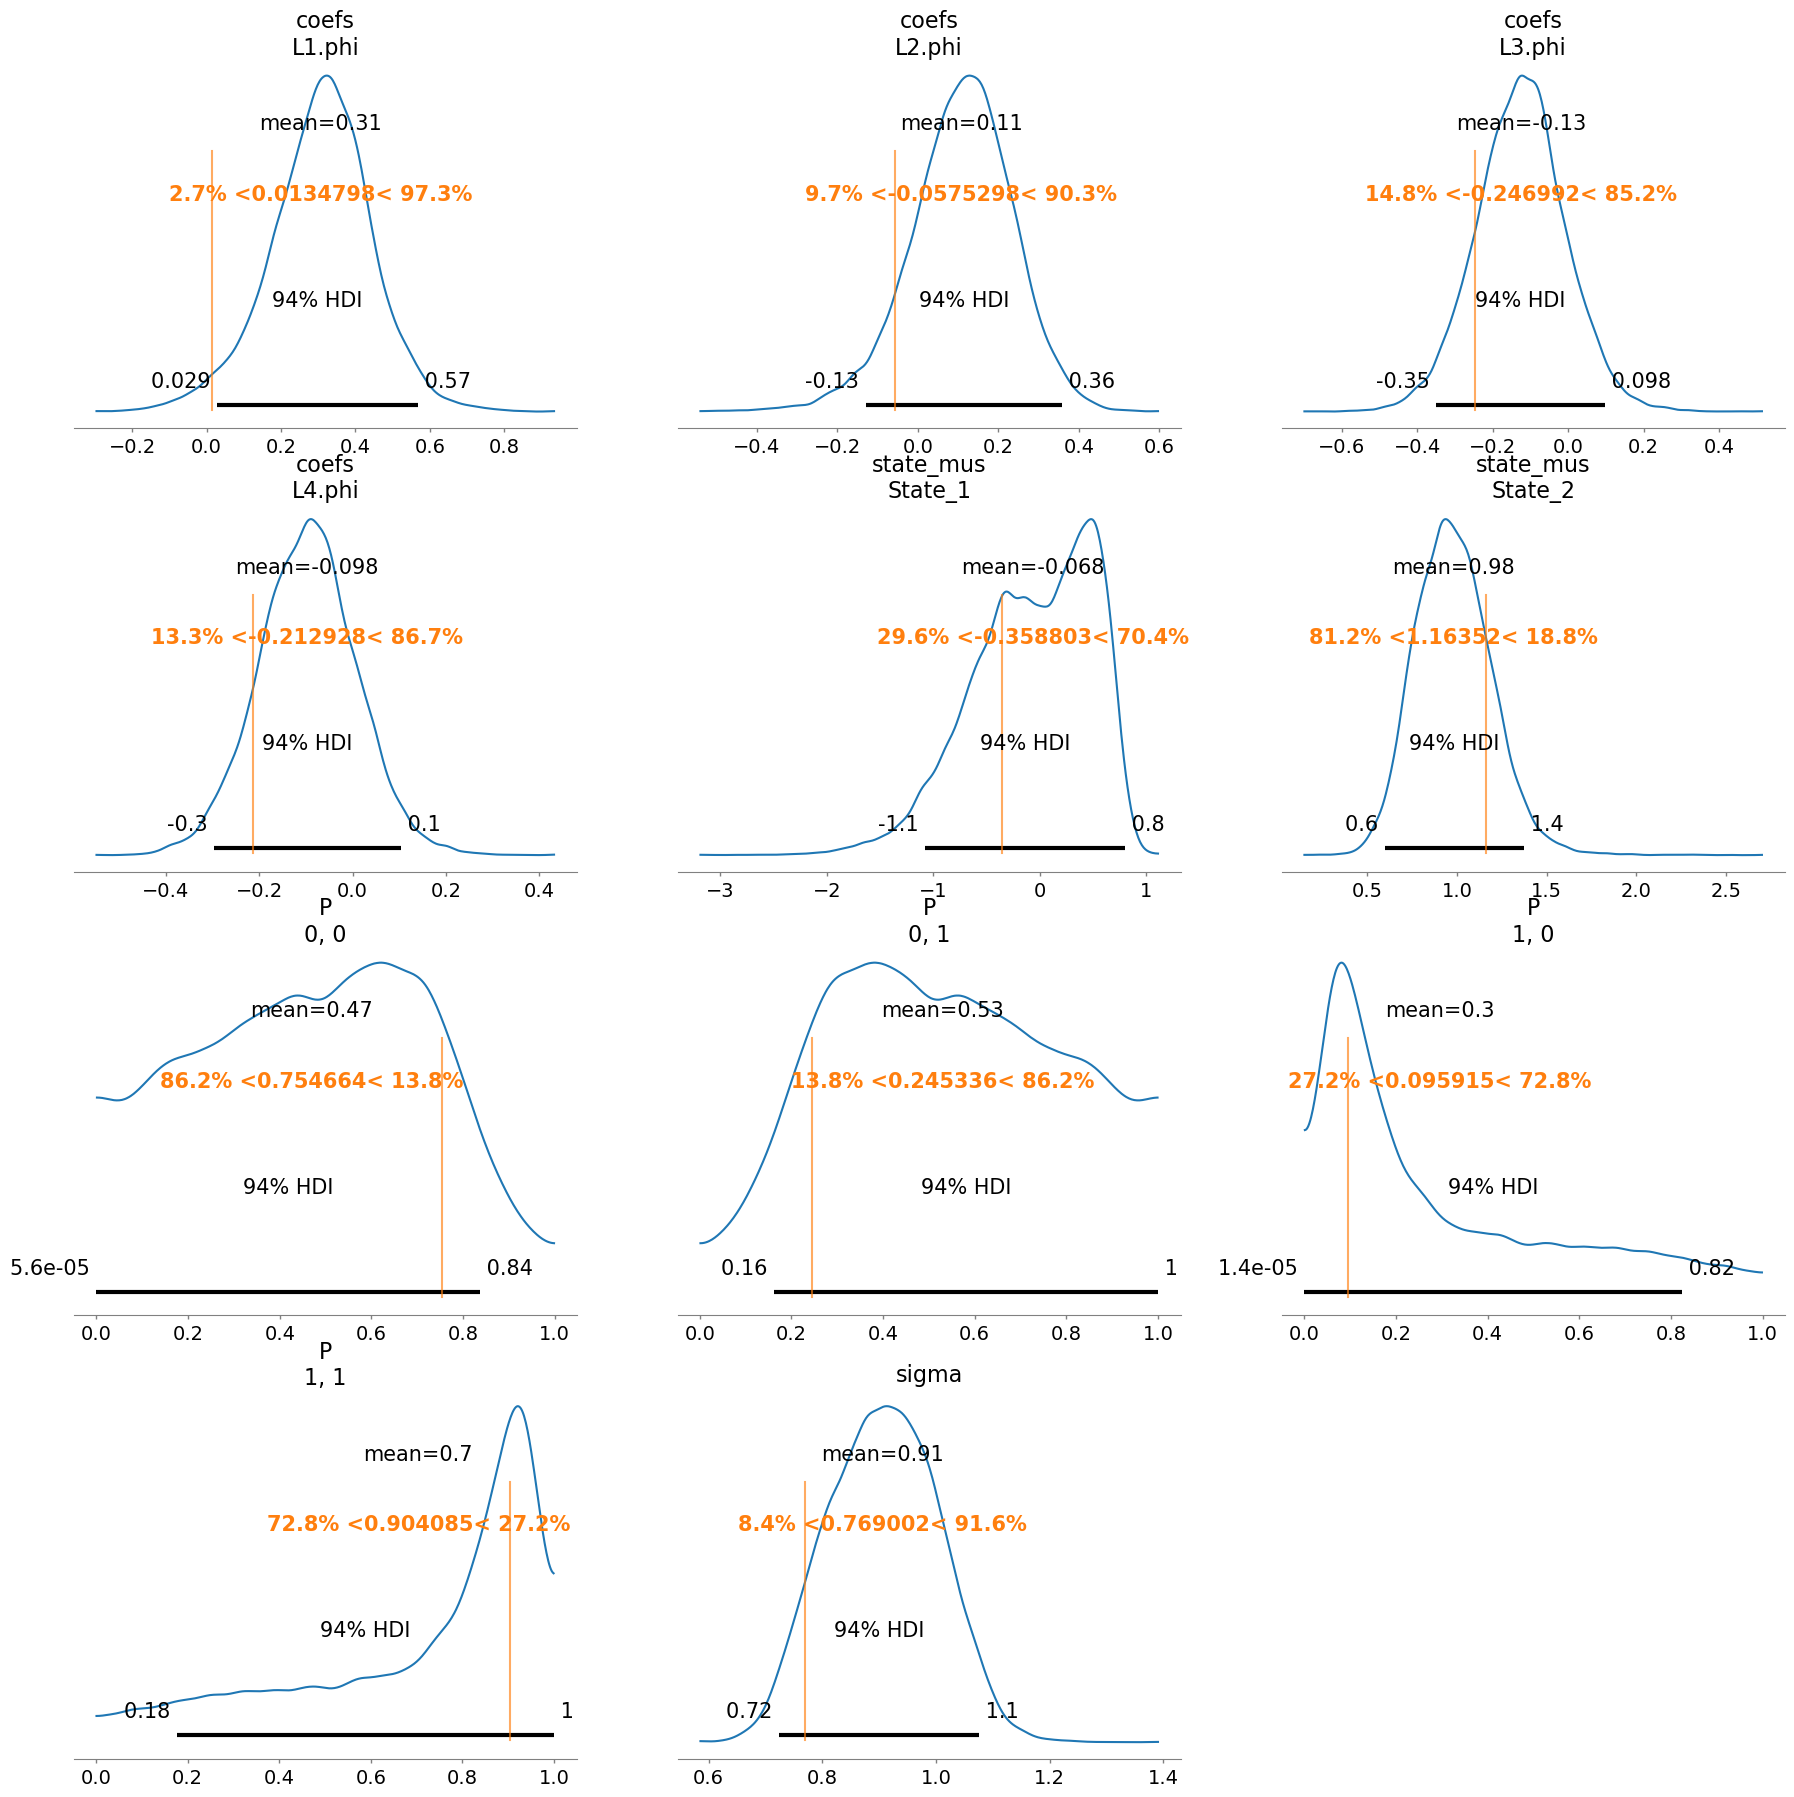

In [19]:
az.plot_posterior(
    idata, var_names=["coefs", "state_mus", "P", "sigma"], ref_val=ref_vals.values.tolist()
);

## Posterior Prediction

In [20]:
with hmm:
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [hidden_states, y_hat]


Output()

In [21]:
post_pred = az.extract(idata, "posterior_predictive").y_hat
post = az.extract(idata)

mu = post_pred.mean("sample")
ci05, ci95 = post_pred.quantile([0.05, 0.95], dim="sample")

In [22]:
sm_preds = res_hamilton.predict()

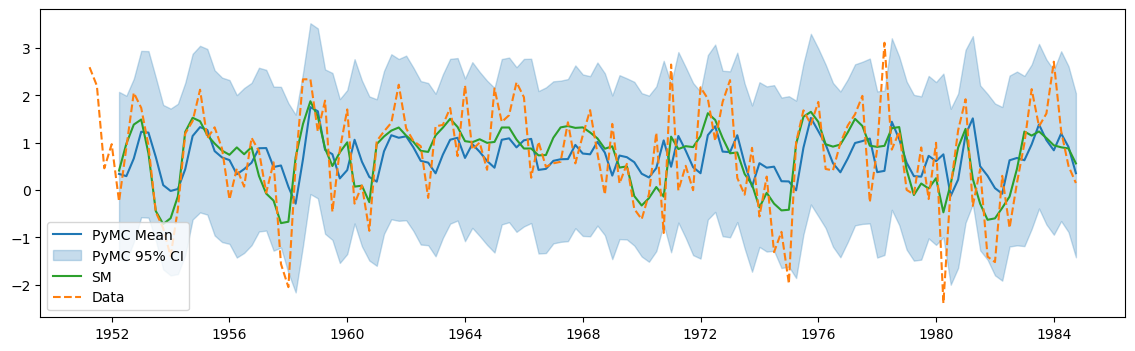

In [29]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(mu.coords["obs_dates"], mu, label="PyMC Mean")
ax.fill_between(
    mu.coords["obs_dates"], ci05, ci95, alpha=0.25, color="tab:blue", label="PyMC 95% CI"
)

ax.plot(sm_preds, color="tab:green", label="SM")
ax.plot(dta_hamilton, ls="--", color="tab:orange", label="Data")

ax.legend()
plt.show()

## Regime Inference

We can consider the probability of seeing a certain state as the fraction of posterior draws corresponding to that state

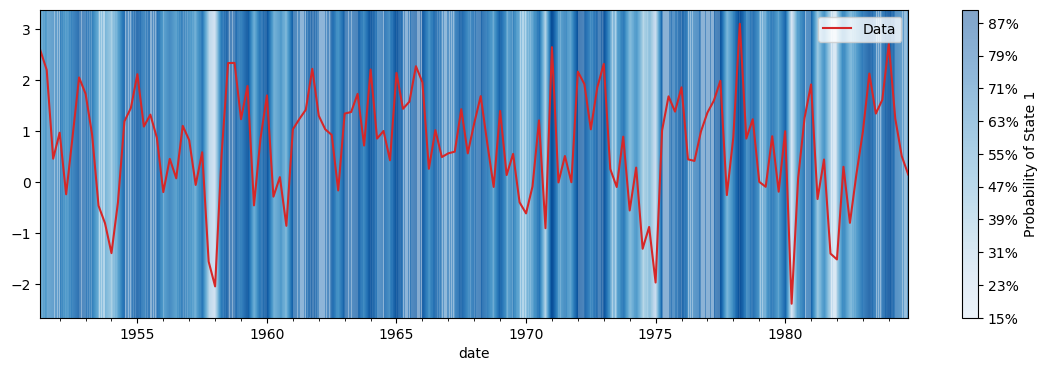

In [30]:
fig, ax = plt.subplots(figsize=(14, 4))
dta_hamilton.plot(ax=ax, color="tab:red", label="Data")

p_state_1 = post.hidden_states.mean(dim=["sample"])
ymin, ymax = ax.get_ylim()
y = np.linspace(ymin, ymax, T)
z, _ = np.meshgrid(p_state_1, p_state_1)

num_bars = 100
contour_plot = ax.contourf(dta_hamilton.index, y, z, num_bars, cmap="Blues", alpha=0.5, zorder=0)
contour_plot.set_clim(vmin=0, vmax=1)

cbar = fig.colorbar(
    contour_plot, ax=ax, label="Probability of State 1", format=mtick.PercentFormatter(xmax=1)
)

ax.legend()
plt.show()